## New York City Taxi Fare Prediction


#### Life cycle of Machine learning Project

- Understanding the Problem Statement
- Data Collection
- Data Checks to perform
- Exploratory data analysis
- Data Pre-Processing
- Model Training
- Choose best model

### 1) Problem statement
- This project understands how the taxi fare is affected by other variables such as Pickup Longitude, Pickup Latitude, Drop-off Longitude, Drop-off Latitude, Pickup Datetime and Passenger Count.


### 2) Data Collection
- Dataset Source - https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction
- The data consists of 8 column and 250000 rows.

### 2.1 Import Data and Required Packages
####  Importing Pandas, Numpy, Matplotlib, Seaborn, random, folium, Geodesic and Warings Library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import folium # To draw map of NYC pickup and drop points
from geographiclib.geodesic import Geodesic # To calulate distance and direction 
import warnings
warnings.filterwarnings('ignore')

#### Import the CSV Data as Pandas DataFrame

In [2]:
# parse_dates for pickup_datetime column to be able to use date and time 
df = pd.read_csv("train.csv",nrows=250000, parse_dates=["pickup_datetime"])

#### Show Top 5 Records

In [3]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


#### Shape of the dataset

In [4]:
df.shape

(250000, 8)

### 2.2 Dataset information

- key : not an important feature it's required only to submit results to kaggle competition 
- pickup_datetime : indicating when the taxi ride started.
- pickup_longitude : for longitude coordinate of where the taxi ride started.
- pickup_latitude : for latitude coordinate of where the taxi ride started.
- dropoff_longitude : for longitude coordinate of where the taxi ride ended.
- dropoff_latitude : for latitude coordinate of where the taxi ride ended.
- passenger_count : indicating the number of passengers in the taxi ride.

### 3. Data Checks to perform

- Check Missing values
- Check Duplicates
- Check data type
- Check the number of unique values of each column
- Check statistics of data set
- Check various categories present in the different categorical column

### 3.1 Check Missing values

In [5]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    2
dropoff_latitude     2
passenger_count      0
dtype: int64

#### There are 2 missing values in dropoff_longitude and dropoff_latitude out of 250000, so we can drop them

### 3.2 Drop missing values 

In [6]:
df.dropna(inplace = True, ignore_index = True)

### 3.3 Check Duplicates

In [7]:
df.duplicated().sum()

0

#### There are no duplicates  values in the data set

### 3.4 Check data types

In [8]:
# Check null and Dtype 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249998 entries, 0 to 249997
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                249998 non-null  object             
 1   fare_amount        249998 non-null  float64            
 2   pickup_datetime    249998 non-null  datetime64[ns, UTC]
 3   pickup_longitude   249998 non-null  float64            
 4   pickup_latitude    249998 non-null  float64            
 5   dropoff_longitude  249998 non-null  float64            
 6   dropoff_latitude   249998 non-null  float64            
 7   passenger_count    249998 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 15.3+ MB


- pickup_datetime need to be converteed into new columns (Year, Month, Day, Hour)
- Using longitude and latitude I can calculate distance and direction for each trip

### 3.5 Extract Year, Weekday, Month and Hour information

In [9]:
# Extract year, weekday, and hour information
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month  
df['weekday'] = df['pickup_datetime'].dt.weekday  # Monday=0, Sunday=6
df['hour'] = df['pickup_datetime'].dt.hour

# Drop pickup_datetime as we don't needed any more 
df.drop("pickup_datetime", axis=1, inplace = True)

# Reset the index 
df.reset_index(drop = True, inplace = True)

### 3.6 Checking the number of unique values of each column

In [10]:
df.nunique()

key                    3600
fare_amount            1309
pickup_longitude      76995
pickup_latitude       92521
dropoff_longitude     84509
dropoff_latitude     101044
passenger_count           7
year                      7
month                    12
weekday                   7
hour                     24
dtype: int64

### 3.7 Check statistics of data set

In [11]:
# Show statistics about the dataset
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
count,249998.000000,249998.000000,249998.000000,249998.000000,249998.000000,249998.000000,249998.000000,249998.000000,249998.000000,249998.000000
mean,11.357539,-72.524347,39.927393,-72.526395,39.928904,1.683369,2011.741066,6.273462,3.040640,13.507964
std,9.937744,11.503525,9.394350,10.637970,6.631379,1.307365,1.862544,3.441124,1.948255,6.508319
min,-44.900000,-740.000000,-3116.285383,-1251.195890,-1189.615440,0.000000,2009.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992035,40.734987,-73.991327,40.734070,1.000000,2010.000000,3.000000,1.000000,9.000000
50%,8.500000,-73.981763,40.752769,-73.980090,40.753211,1.000000,2012.000000,6.000000,3.000000,14.000000
75%,12.500000,-73.967077,40.767142,-73.963549,40.768073,2.000000,2013.000000,9.000000,5.000000,19.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000,2015.000000,12.000000,6.000000,23.000000


#### Insight
- Some trips have negative fare and some trips costs 500 USD
- The mean for `fare_amount` is $11.3 so the trips with very high fare consider to be outliers
- some longitude and latitude outside the range of NYC **40.4774° N to  40.9176° N** and **-74.2591° W to  -73.7004° W**
- According to `passenger_count`, some trips are recorded with 0 passenger 
- Recordes are for trips between 2009 to 2015

### 3.8 Remove samples that are outised the NYC perimeter and save it as new DataFrame 

In [12]:
# Remove samples that are out of the range of longitude and latitude of NYC 
df_NYC = df[(df["pickup_longitude"] >= -74.2591) & (df["pickup_longitude"] <= -73.7004)]
df_NYC = df_NYC[(df_NYC["pickup_latitude"] >= 40.4774) & (df_NYC["pickup_latitude"] <= 40.9176)]
df_NYC = df_NYC[(df_NYC["dropoff_longitude"] >= -74.2591) & (df_NYC["dropoff_longitude"] <= -73.7004)]
df_NYC = df_NYC[(df_NYC["dropoff_latitude"] >= 40.4774) & (df_NYC["dropoff_latitude"] <= 40.9176)]

# Reset df index
df_NYC = df_NYC.reset_index(drop=True)

### 3.9 Remove samples with fare less than the initial taxi fare of $2.5

In [13]:
# Remove samples with less than initial fare ($2.5)
df_NYC = df_NYC[df_NYC["fare_amount"]>=2.5] 
# Reset df index
df_NYC = df_NYC.reset_index(drop=True)

### 3.10 Calculate and add columns for trip's "Distance in Mile" and "Direction" Using Geodesic method

In [14]:
# Create a Geodesic object
geod = Geodesic.WGS84

# Function to calculate distance and azimuth between pickup and drop-off points
def calculate_distance_azimuth(row):
    pickup_lat = row['pickup_latitude']
    pickup_lon = row['pickup_longitude']
    
    dropoff_lat = row['dropoff_latitude']
    dropoff_lon = row['dropoff_longitude']
    
    result = geod.Inverse(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon)
    
    distance_meters = result['s12']
    distance_miles = distance_meters / 1609.34  # Convert meters to miles
    azimuth1 = result['azi1']
    
    return distance_miles, azimuth1

In [15]:
# Apply the function to each row in the DataFrame
df_NYC[['distance_miles', 'azimuth']] = df_NYC.apply(calculate_distance_azimuth, axis=1, result_type='expand')

In [16]:
df_NYC

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,distance_miles,azimuth
0,26:21.0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17,0.639766,167.192697
1,52:16.0,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16,5.246524,21.573931
2,35:00.0,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0,0.863169,-148.869017
3,30:42.0,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4,1.737227,-7.701492
4,51:00.0,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7,1.241713,28.896195
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244449,36:48.0,6.1,-73.992554,40.758295,-74.002086,40.739535,2,2012,6,5,0,1.387777,-158.869574
244450,24:00.0,11.5,-73.990002,40.689777,-73.953538,40.713095,1,2013,3,6,21,2.501133,49.949281
244451,00:33.0,4.5,-73.992934,40.719706,-73.986884,40.722294,1,2013,9,5,5,0.364380,60.651593
244452,22:23.0,10.5,-73.979372,40.761691,-73.987105,40.755775,1,2014,9,1,15,0.575565,-135.171700


### 3.11 Calculate and add columns for estimated fare whcih = Initial Fare (2.5 USD) + Meter Rate (2.5$/mile)

In [17]:
df_NYC["est_fare"] = ((df_NYC.distance_miles*2.5) + 2.5)

In [18]:
# Remove the column from the DataFrame
column_to_move = df_NYC.pop('fare_amount')  

# Add the column back to the DataFrame as the last column
df_NYC['act_fare'] = column_to_move

In [19]:
df_NYC

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,distance_miles,azimuth,est_fare,act_fare
0,26:21.0,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17,0.639766,167.192697,4.099415,4.5
1,52:16.0,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16,5.246524,21.573931,15.616311,16.9
2,35:00.0,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0,0.863169,-148.869017,4.657922,5.7
3,30:42.0,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4,1.737227,-7.701492,6.843069,7.7
4,51:00.0,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7,1.241713,28.896195,5.604282,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244449,36:48.0,-73.992554,40.758295,-74.002086,40.739535,2,2012,6,5,0,1.387777,-158.869574,5.969444,6.1
244450,24:00.0,-73.990002,40.689777,-73.953538,40.713095,1,2013,3,6,21,2.501133,49.949281,8.752832,11.5
244451,00:33.0,-73.992934,40.719706,-73.986884,40.722294,1,2013,9,5,5,0.364380,60.651593,3.410949,4.5
244452,22:23.0,-73.979372,40.761691,-73.987105,40.755775,1,2014,9,1,15,0.575565,-135.171700,3.938913,10.5


### 4. Exploring Data ( Visualization )
#### 4.1 Visualize trips counts over years  
- Bar Chart

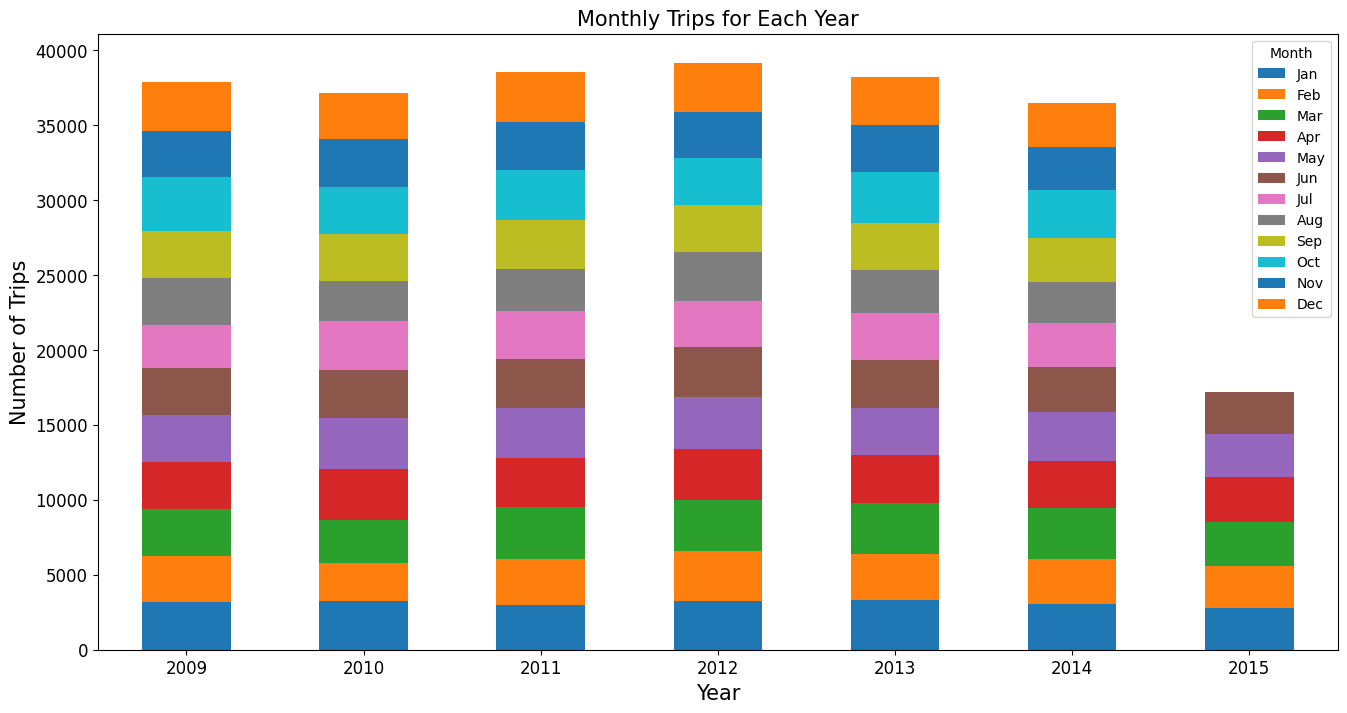

In [20]:
months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Group data by year and month, and count occurrences
grouped = df_NYC.groupby(['year', 'month']).size().unstack(fill_value=0)

# Plotting
grouped.plot(kind='bar', stacked=True, figsize=(16,8))
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Trips', fontsize=15)
plt.title('Monthly Trips for Each Year', fontsize=15)
plt.legend(title='Month', labels=[f'{i}' for i in months])
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)  # Increase font size for y-axis labels
plt.show()

#### Insight
- The number of trips each year is almost equal  
- 2015 recoders are till Jun only 

#### 4.2 Visualize fare amout distribution. 
- Histogram
- Kernel Distribution Function (KDE)

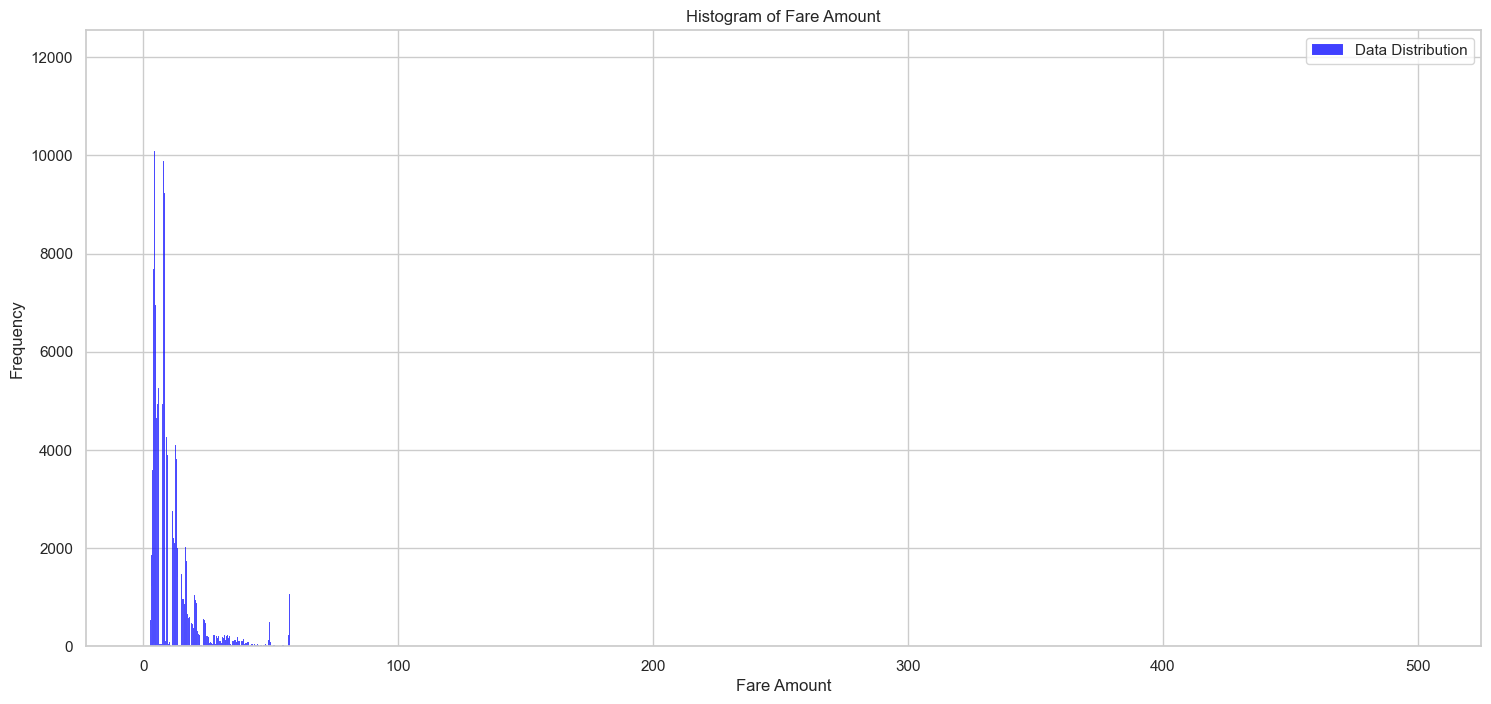

In [21]:
# Create a histogram plot using sns.histplot for fare_amount
sns.set(style="whitegrid")

plt.figure(figsize=(18,8))
sns.histplot(data=df_NYC["act_fare"], color='blue', label='Data Distribution', kde=False);
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Fare Amount')
plt.legend()
plt.show()

##### Insight
- Fare amout for most of the samples are less than $60 so we can drop recordes with fare cost larger than 60 

##### Remove samples with fare cost larger than $60

In [22]:
df_NYC = df_NYC[df_NYC["act_fare"] < 60]

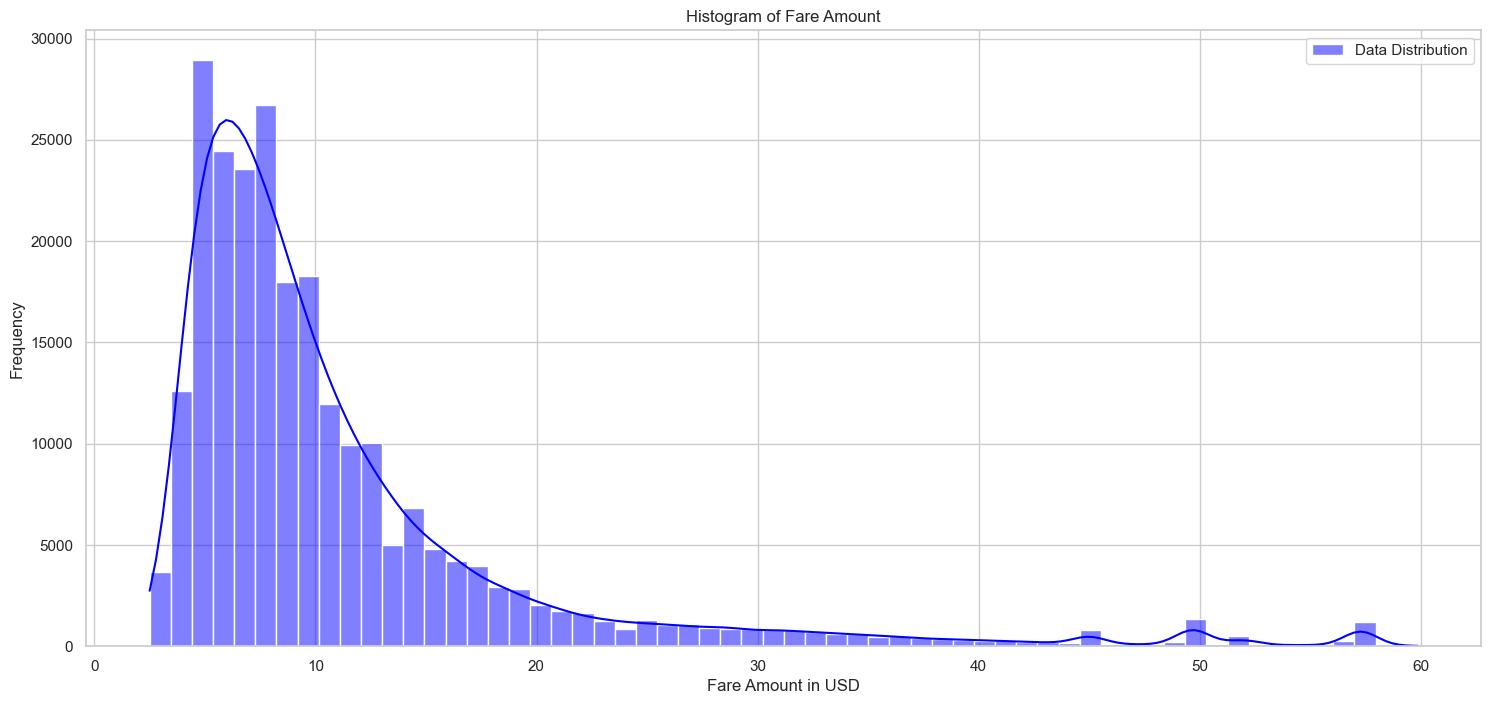

In [23]:
# Create a histogram plot using sns.histplot
plt.figure(figsize=(18,8))
sns.histplot(data=df_NYC["act_fare"], bins=60, color='blue', label='Data Distribution', kde=True)
plt.xlabel('Fare Amount in USD')
plt.ylabel('Frequency')
plt.title('Histogram of Fare Amount')
plt.legend()
plt.show()

##### Insight
- The fare amount for most of the samples is around $6, indicating that people are most likely to use taxis for short trips inside NYC

#### 4.3 Visualize distance distribution to get insights. 
- Histogram
- Kernel Distribution Function (KDE)

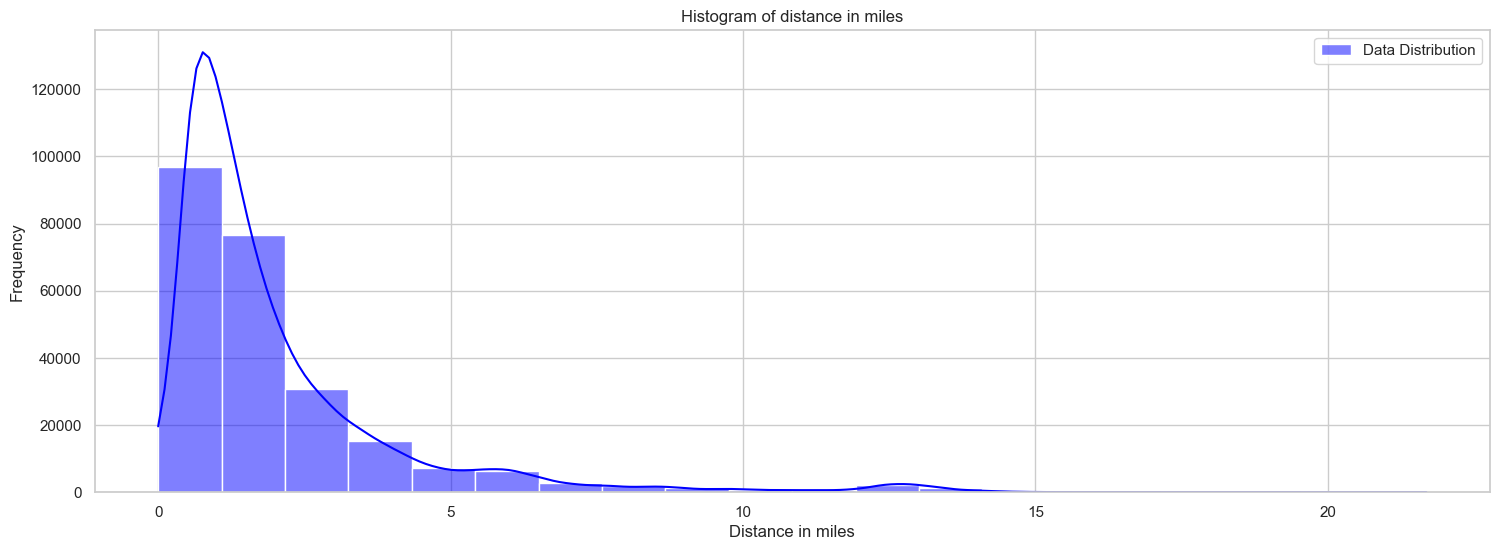

In [24]:
# Create a histogram plot using sns.histplot
plt.figure(figsize=(18,6))
sns.histplot(data= df_NYC["distance_miles"].values, bins=20, color='blue', label='Data Distribution', kde=True)

plt.xlabel('Distance in miles')
plt.ylabel('Frequency')
plt.title('Histogram of distance in miles')
plt.legend()
plt.show()

In [25]:
df_NYC["distance_miles"].describe()

count    243890.000000
mean          2.038487
std           2.164117
min           0.000000
25%           0.780532
50%           1.336399
75%           2.418966
max          21.685189
Name: distance_miles, dtype: float64

##### Insight
- Distance for most of the samples are less than 15 miles so we can drop recordes with distance larger than 15 
- There is trips with 0 miles so we have to drop them, I will set a threshould of min 0.1 mile 

##### Remove samples with distance larger than 15 miles

In [26]:
df_NYC = df_NYC[(df_NYC["distance_miles"] > 0.1) & (df_NYC["distance_miles"] < 15) ]

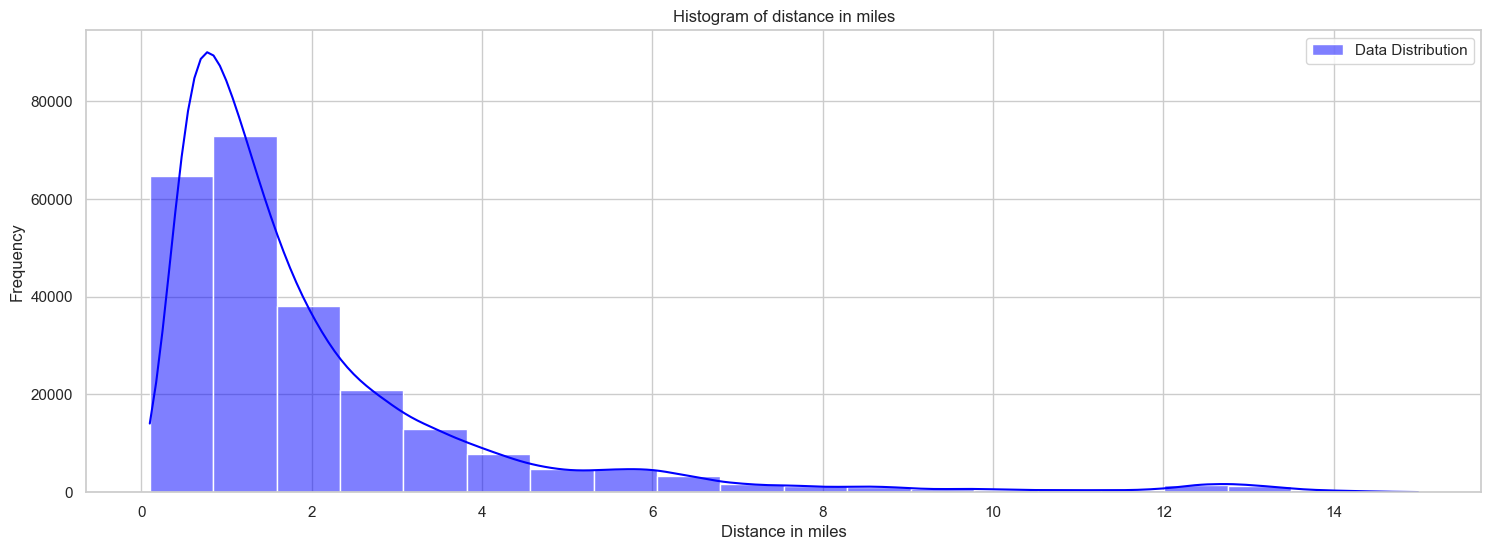

In [27]:
# Create a histogram plot using sns.histplot
plt.figure(figsize=(18,6))
sns.histplot(data= df_NYC["distance_miles"].values, bins=20, color='blue', label='Data Distribution', kde=True)

plt.xlabel('Distance in miles')
plt.ylabel('Frequency')
plt.title('Histogram of distance in miles')
plt.legend()
plt.show()

#### 4.5 Visualise The Relation Between Fare and Passenger Count 
- Bar Chart
- Histogram plot

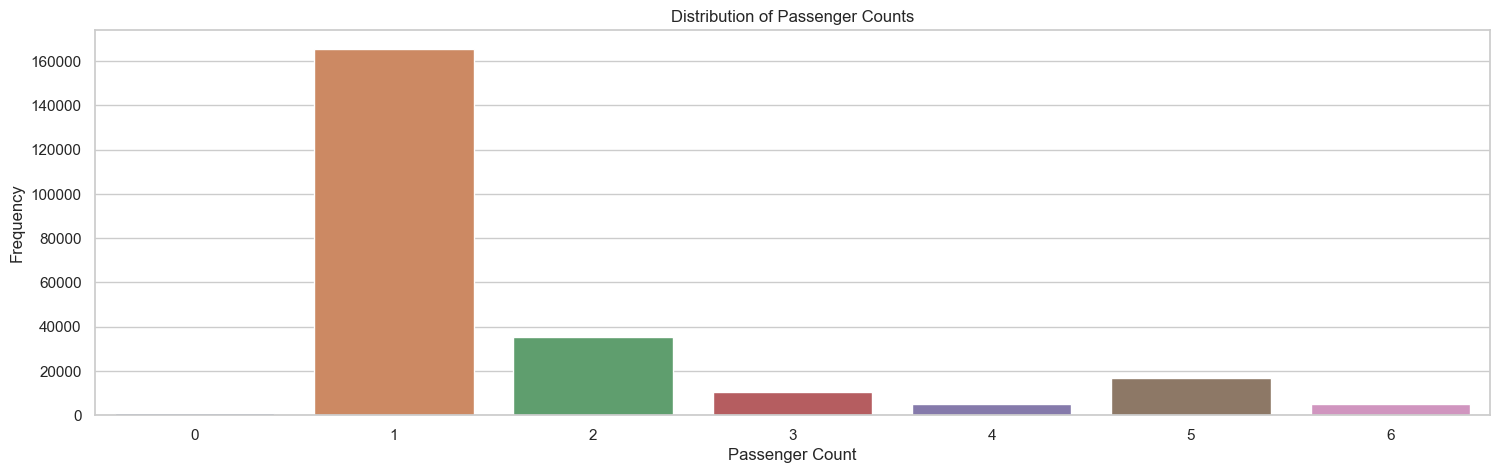

In [28]:
# Create a countplot for the 'passenger_count' column
plt.figure(figsize=(18,5))
sns.countplot(data=df_NYC, x='passenger_count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.title('Distribution of Passenger Counts')
plt.show()

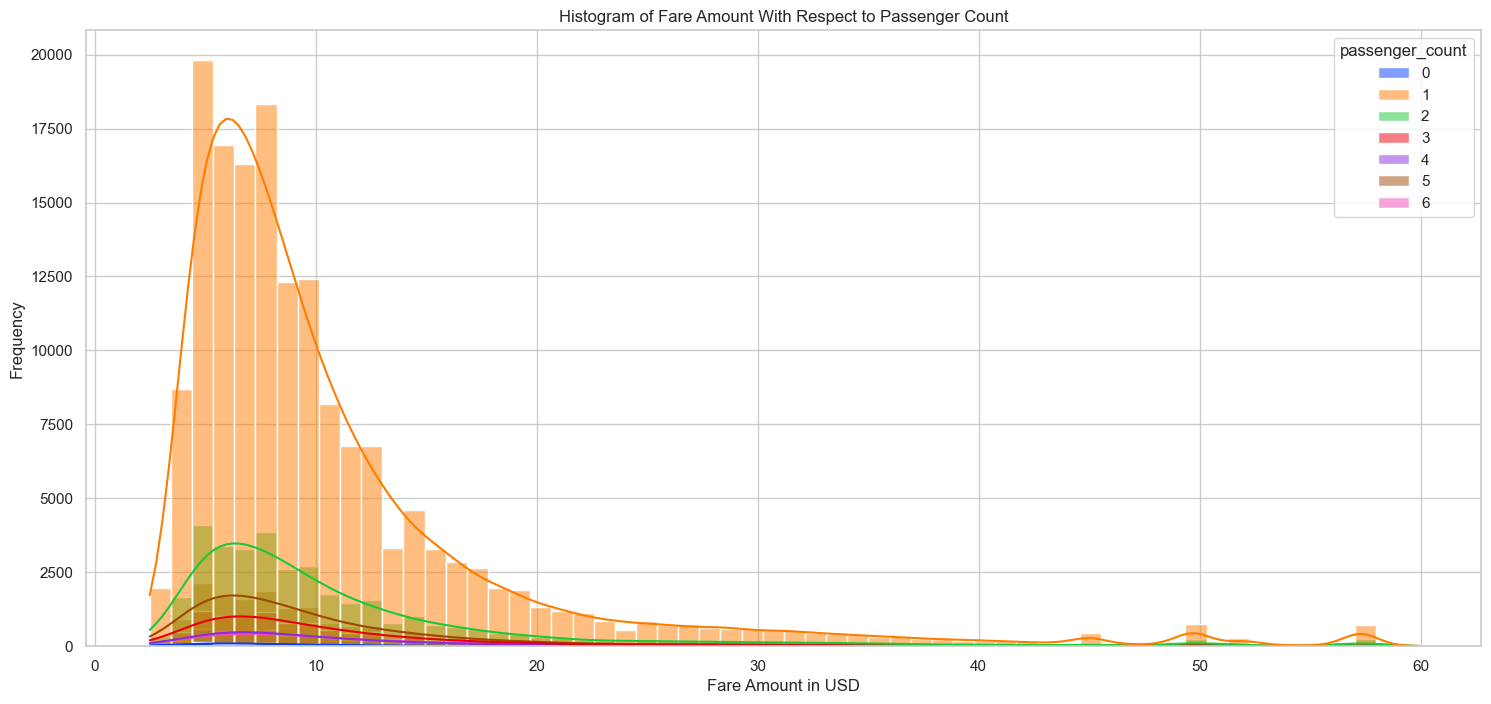

In [30]:
# Create a histogram plot using sns.histplot
plt.figure(figsize=(18,8))
sns.histplot(data=df_NYC, x="act_fare",bins=60, palette='bright', label='passenger_count', kde=True, hue='passenger_count')
plt.xlabel('Fare Amount in USD')
plt.ylabel('Frequency')
plt.title('Histogram of Fare Amount With Respect to Passenger Count')
plt.show()

##### Insight
- most trips with only 1 passanger and passanger count seemes to be not important feature and we can drop it 

##### Drop `passenger_count`

In [32]:
df_NYC.drop("passenger_count", inplace=True, axis=1)
df_NYC.reset_index(drop = True, inplace= True)

#### 4.6 Visualise The Relation Between Fare and Distance 
- Scatter plot

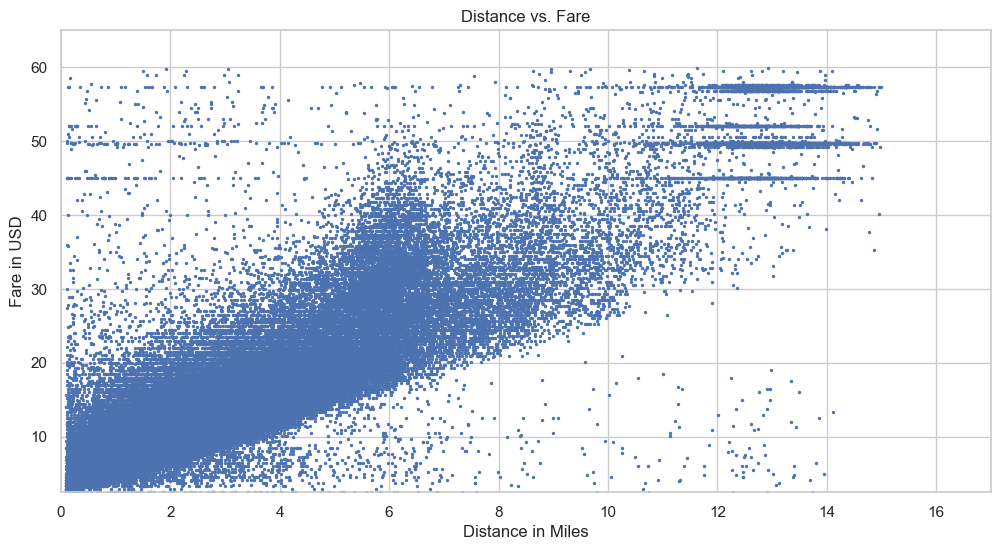

In [33]:
plt.figure(figsize=(12, 6))

plt.scatter(df_NYC["distance_miles"],df_NYC["act_fare"],s=2)
# Set axis boundaries
plt.xlim(0, 17)  # Set min_x and max_x as your desired values
plt.ylim(2.5, 65)  # Set min_y and max_y as your desired values
plt.xlabel('Distance in Miles')
plt.ylabel('Fare in USD')
plt.title('Distance vs. Fare')
plt.show()

#### Insight
- There is linear relation between distance and fare
- Some trips with long distance has low fare maybe it was discounted trip or the passanger used an offer, hance there is no enough data to explain this, its better to discard them as they may consider outliers
- Some trips with short distance has high fare maybe it from/to airports 

In [34]:
df_NYC = df_NYC[df_NYC.act_fare > (df_NYC.est_fare * 0.7 )]

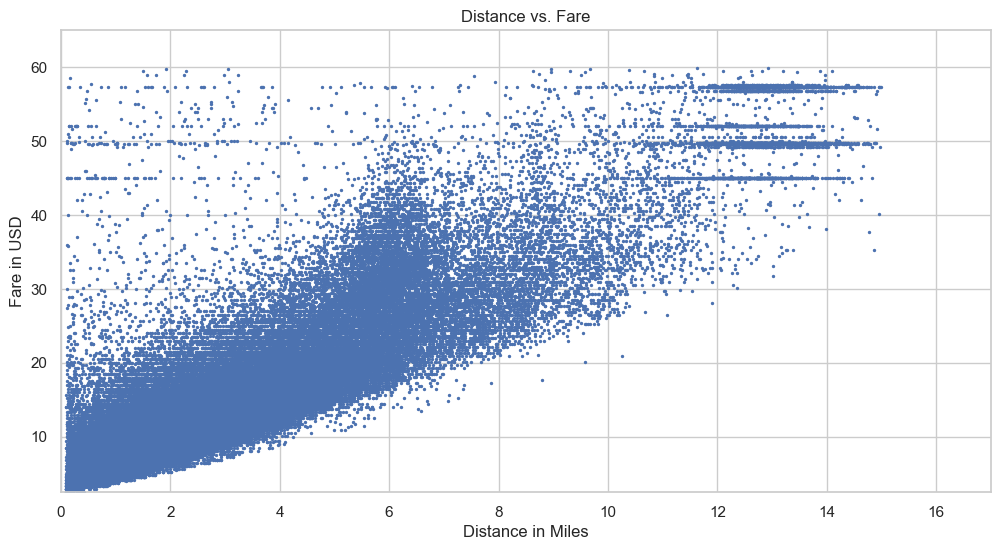

In [35]:
plt.figure(figsize=(12, 6))

plt.scatter(df_NYC["distance_miles"],df_NYC["act_fare"],s=2)
# Set axis boundaries
plt.xlim(0, 17)  # Set min_x and max_x as your desired values
plt.ylim(2.5, 65)  # Set min_y and max_y as your desired values
plt.xlabel('Distance in Miles')
plt.ylabel('Fare in USD')
plt.title('Distance vs. Fare')
plt.show()

#### Insight
- There are trips with const fare between 40 and $60 it may be from/to airports 

#### 4.6 Visualise relation beetween distance and fare from/to airprts
- scatter plot

##### Check if the pickup or dropoff point at JFK Airport and add new column "JFK_Airport"

In [42]:
# JFK Airport's latitude and longitude
jfk_lat = 40.6413
jfk_lon = -73.7781

# Create a Geodesic object
geod = Geodesic.WGS84

# Radius of the perimeter in meters (e.g., 1 miles)
radius_meters = 2 * 1609.34

# Function to check if a location is within the perimeter
def is_within_perimeter(lat, lon):
    result = geod.Inverse(jfk_lat, jfk_lon, lat, lon)
    return result['s12'] <= radius_meters

# Create a new column and assign 1 if within perimeter, else assign 0
df_NYC['JFK_Airport'] = df_NYC.apply(lambda row: 1 if is_within_perimeter(row['pickup_latitude'], row['pickup_longitude']) else 0, axis=1)
df_NYC['JFK_Airport'] = df_NYC.apply(lambda row: 1 if is_within_perimeter(row['dropoff_latitude'], row['dropoff_longitude'])else row['JFK_Airport'], axis=1)

##### Check if the pickup or dropoff point at LaGuardia Airport and add new column "LGA_Airport"

In [43]:
# LaGuardia Airport's latitude and longitude
LGA_lat = 40.7769
LGA_lon = -73.8740

# Create a Geodesic object
geod = Geodesic.WGS84

# Radius of the perimeter in meters (e.g., 1 miles)
radius_meters = 2 * 1609.34

# Function to check if a location is within the perimeter
def is_within_perimeter(lat, lon):
    result = geod.Inverse(LGA_lat, LGA_lon, lat, lon)
    return result['s12'] <= radius_meters

# Create a new column and assign 1 if within perimeter, else assign 0
df_NYC['LGA_Airport'] = df_NYC.apply(lambda row: 1 if is_within_perimeter(row['pickup_latitude'], row['pickup_longitude']) else 0, axis=1)
df_NYC['LGA_Airport'] = df_NYC.apply(lambda row: 1 if is_within_perimeter(row['dropoff_latitude'], row['dropoff_longitude']) else row['LGA_Airport'], axis=1)

##### Check if the pickup or dropoff point at Newark Liberty International Airport and add new column "EWR_Airport"

In [44]:
# Newark Liberty International Airport's latitude and longitude
EWR_lat = 40.6895
EWR_lon = -74.1745

# Create a Geodesic object
geod = Geodesic.WGS84

# Radius of the perimeter in meters (e.g., 1 miles)
radius_meters = 2 * 1609.34

# Function to check if a location is within the perimeter
def is_within_perimeter(lat, lon):
    result = geod.Inverse(EWR_lat, EWR_lon, lat, lon)
    return result['s12'] <= radius_meters

# Create a new column and assign 1 if within perimeter, else assign 0
df_NYC['EWR_Airport'] = df_NYC.apply(lambda row: 1 if is_within_perimeter(row['pickup_latitude'], row['pickup_longitude']) else 0, axis=1)
df_NYC['EWR_Airport'] = df_NYC.apply(lambda row: 1 if is_within_perimeter(row['dropoff_latitude'], row['dropoff_longitude']) else row['EWR_Airport'], axis=1)

In [45]:
df_City = df_NYC[(df_NYC['EWR_Airport'] == 0) & (df_NYC['LGA_Airport'] == 0) & (df_NYC['JFK_Airport'] == 0)]
df_JFK = df_NYC[df_NYC['JFK_Airport'] == 1]
df_LGA = df_NYC[df_NYC['LGA_Airport'] == 1]
df_EWR = df_NYC[df_NYC['EWR_Airport'] == 1]

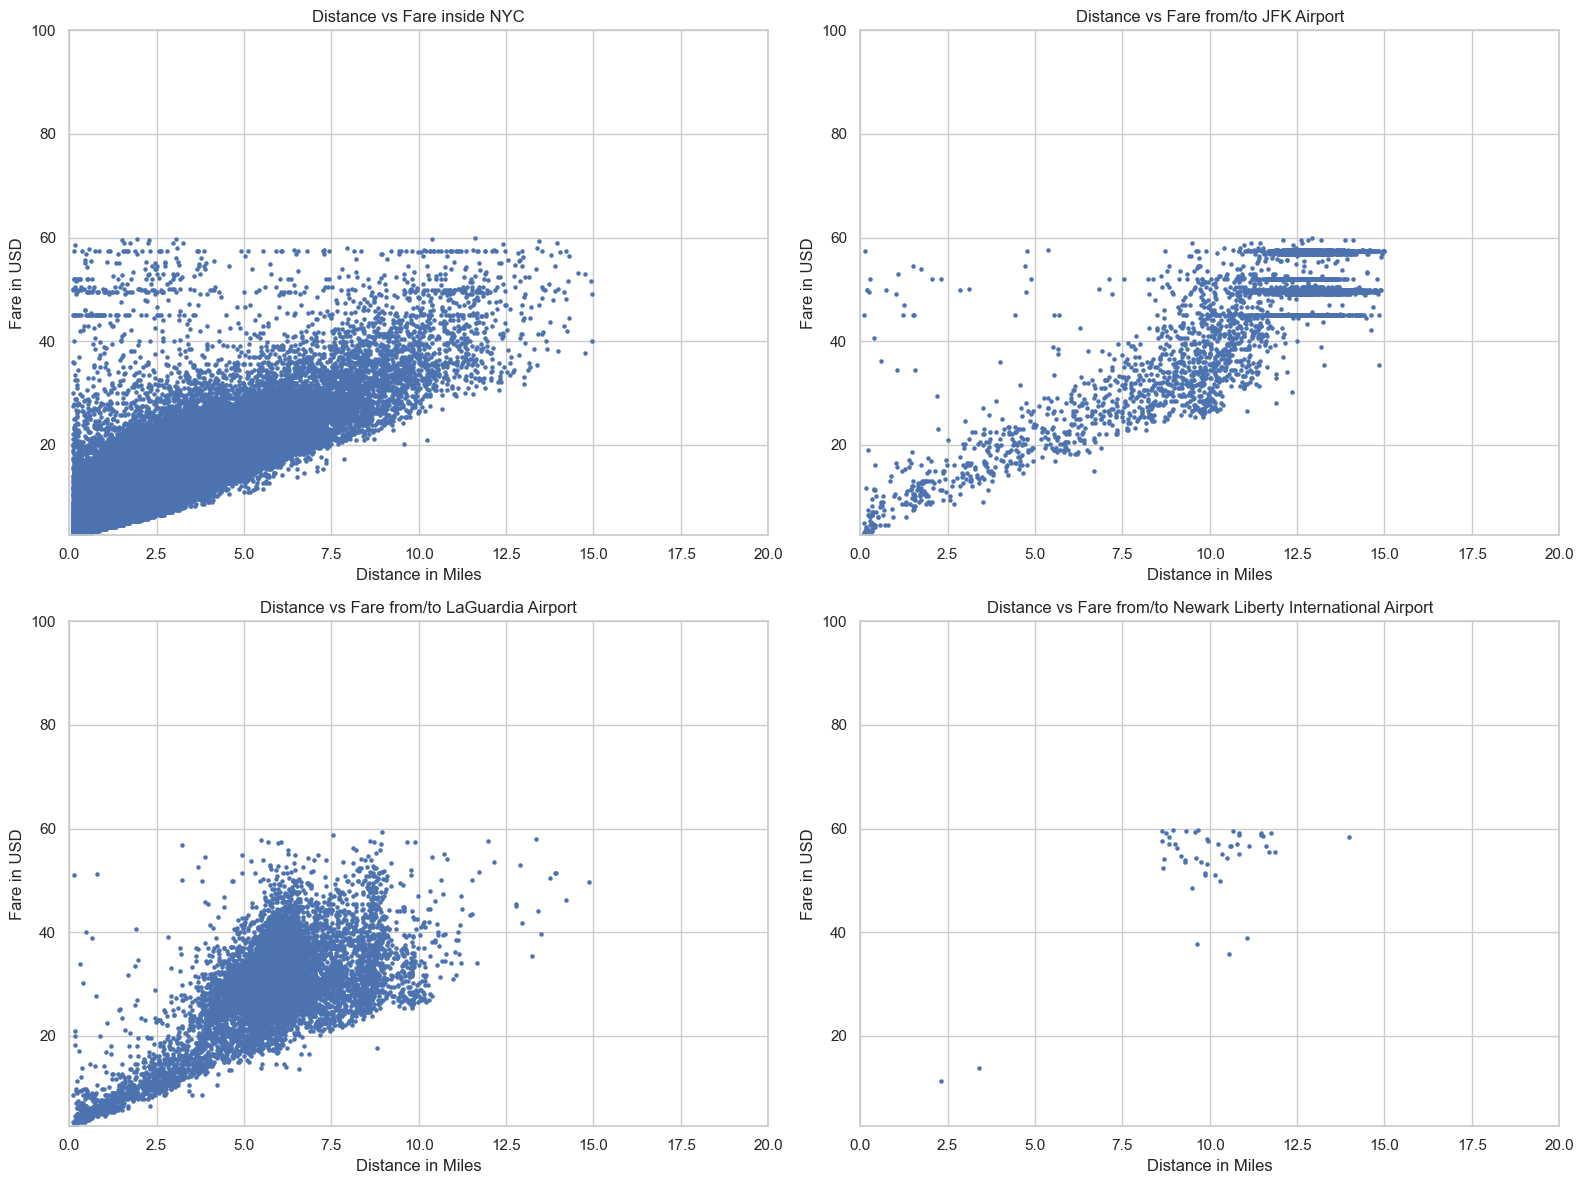

In [46]:
# Create a 2x2 grid of subplots
plt.figure(figsize=(16, 12))

# Plot 1: Distance vs. Fare
plt.subplot(2, 2, 1)
plt.scatter(df_City["distance_miles"], df_City["act_fare"], s=5)
plt.xlim(0, 20)
plt.ylim(2.5, 100)
plt.xlabel('Distance in Miles')
plt.ylabel('Fare in USD')
plt.title('Distance vs Fare inside NYC')

# Plot 2: Distance vs. Fare JFK
plt.subplot(2, 2, 2)
plt.scatter(df_JFK["distance_miles"], df_JFK["act_fare"], s=5)
plt.xlim(0, 20)
plt.ylim(2.5, 100)
plt.xlabel('Distance in Miles')
plt.ylabel('Fare in USD')
plt.title('Distance vs Fare from/to JFK Airport')

# Plot 3: Distance vs. Fare LGA
plt.subplot(2, 2, 3)
plt.scatter(df_LGA["distance_miles"], df_LGA["act_fare"], s=5)
plt.xlim(0, 20)
plt.ylim(2.5, 100)
plt.xlabel('Distance in Miles')
plt.ylabel('Fare in USD')
plt.title('Distance vs Fare from/to LaGuardia Airport')

# Plot 4: Distance vs. Fare EWR
plt.subplot(2, 2, 4)
plt.scatter(df_EWR["distance_miles"], df_EWR["act_fare"], s=5)
plt.xlim(0, 20)
plt.ylim(2.5, 100)
plt.xlabel('Distance in Miles')
plt.ylabel('Fare in USD')
plt.title('Distance vs Fare from/to Newark Liberty International Airport')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

#### 4.7 Visualise Pickup and Drop-off points  
- Geoghrapicaly

In [47]:
df_NYC.reset_index(drop=True, inplace= True)

In [48]:
# Generate a list of 1000 unique random numbers within the range
random_indices = random.sample(range(len(df_NYC)), 250)

In [49]:
# Create a map centered on NYC for pickup points
map_NYC = folium.Map(location=[40.776676, -73.971321], zoom_start=11)

In [50]:
# Loop through the DataFrame using the random indices
for idx in random_indices:
    pickup_latitude = df_NYC.at[idx, 'pickup_latitude']
    pickup_longitude = df_NYC.at[idx, 'pickup_longitude']
    folium.Marker([pickup_latitude, pickup_longitude], icon=folium.Icon(color='blue')).add_to(map_NYC)

In [51]:
# Loop through the DataFrame using the random indices
for idx in random_indices:
    dropoff_latitude = df_NYC.at[idx, 'dropoff_latitude']
    dropoff_longitude = df_NYC.at[idx, 'dropoff_longitude']
    folium.Marker([dropoff_latitude, dropoff_longitude], icon=folium.Icon(color='red')).add_to(map_NYC)


In [52]:
map_NYC

#### Insight
- Most of the trips are in Manhattan

### 5. Extra Feature Engineering

- Handle Skewed ditrubution 

#### 5.1 Solve skwed data using log normal distribution method and visualize the output

##### Select the Skewed featuers and apply log function

In [53]:
skewed_fearutes = ["distance_miles","act_fare","est_fare"]
df_not_skewed = df_NYC.copy()
for features in skewed_fearutes:
    df_not_skewed[features] = np.log(df_not_skewed[features])

##### Plot the data distrubution before and after the log normalization

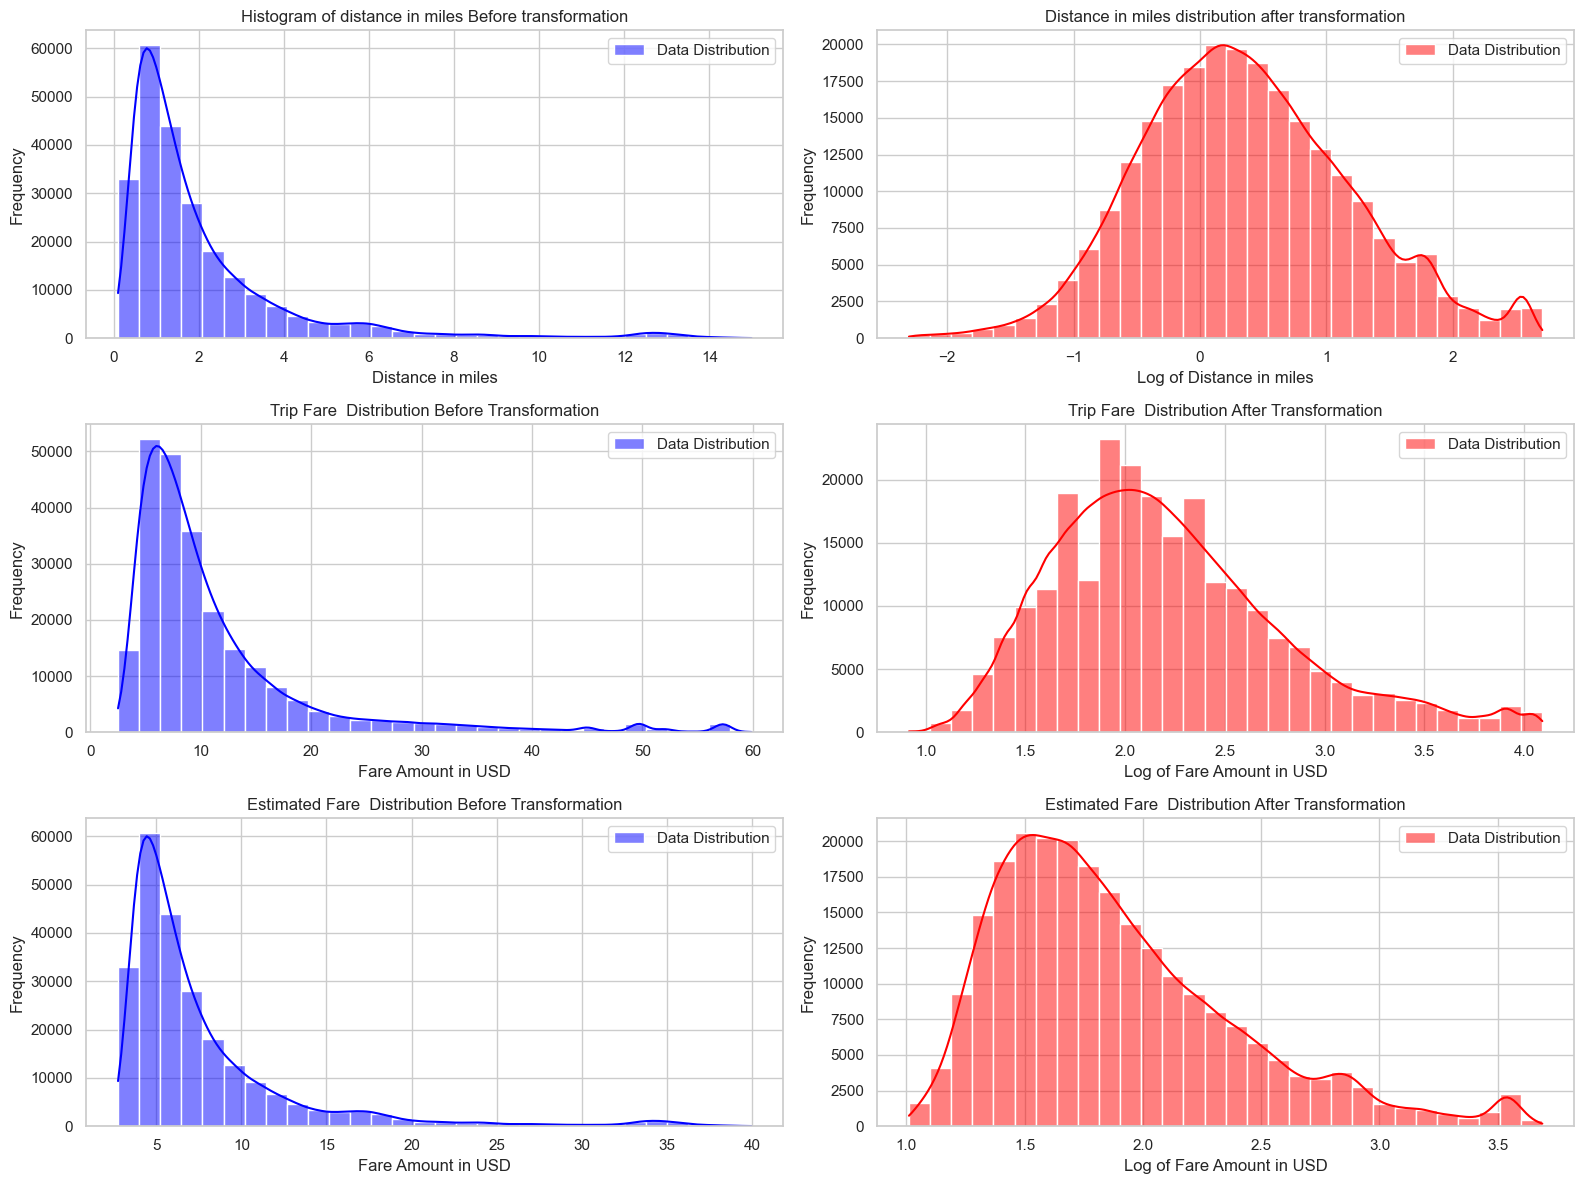

In [54]:
# Create a 3x2 grid of subplots
plt.figure(figsize=(16, 12))

# Plot 1:  Distance in miles distribution Before transformation
plt.subplot(3, 2, 1)
sns.histplot(data= df_NYC["distance_miles"].values, color='blue',bins= 30, label='Data Distribution', kde=True)
plt.xlabel('Distance in miles')
plt.ylabel('Frequency')
plt.title('Histogram of distance in miles Before transformation')
plt.legend()


# Plot 2: Distance in miles distribution after transformation
plt.subplot(3, 2, 2)

sns.histplot(data= df_not_skewed["distance_miles"].values,  color='red',bins= 30, label='Data Distribution', kde=True)
plt.xlabel('Log of Distance in miles')
plt.ylabel('Frequency')
plt.title('Distance in miles distribution after transformation')
plt.legend()

# Plot 3: Trip Fare  Distribution before Transformation
plt.subplot(3, 2, 3)
sns.histplot(data=df_NYC["act_fare"],  color='blue', bins= 30, label='Data Distribution', kde=True)
plt.xlabel('Fare Amount in USD')
plt.ylabel('Frequency')
plt.title('Trip Fare  Distribution Before Transformation')
plt.legend()

# Plot 4: Trip Fare  Distribution After Transformation
plt.subplot(3, 2, 4)
sns.histplot(data=df_not_skewed["act_fare"], color='red', bins= 30, label='Data Distribution', kde=True)
plt.xlabel('Log of Fare Amount in USD')
plt.ylabel('Frequency')
plt.title('Trip Fare  Distribution After Transformation')
plt.legend()

# Plot 5: Estimated Trip Fare  Distribution before Transformation
plt.subplot(3, 2, 5)
sns.histplot(data=df_NYC["est_fare"], color='blue', bins= 30, label='Data Distribution', kde=True)
plt.xlabel('Fare Amount in USD')
plt.ylabel('Frequency')
plt.title('Estimated Fare  Distribution Before Transformation')
plt.legend()

# Plot 6: Estimated Trip Fare  Distribution After Transformation
plt.subplot(3, 2, 6)
sns.histplot(data=df_not_skewed["est_fare"], color='red', bins= 30, label='Data Distribution', kde=True)
plt.xlabel('Log of Fare Amount in USD')
plt.ylabel('Frequency')
plt.title('Estimated Fare  Distribution After Transformation')
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

##### Insight
- Data is now normally distributed 

### 6. Save the new DataFrame as CSV file

In [56]:
df_not_skewed.to_csv('data_EDA.csv', index=False)